# Channel network and REW delineation 

In this notebook, we'll cover the steps required to extract the REW channel network. This tutorial is specific to GRASS 7.0 and the Mac operating system (OS X). We have been most succesful with and recommend installing the GRASS 7.0.x files maintained by Michael Barton, which can be found [here](https://grass.osgeo.org/download/software/mac-osx/). Newer versions of GRASS (`7.3.x`) exist, but have not been tested for this tutorial. NOTE: For newer versions of OS X (El Capitan and on), users may need to implement [this](http://grassmac.wikidot.com) fix to get GRASS to run succesfully. 

In [12]:
%matplotlib inline
from matplotlib import pylab
import os
import sys
from os.path import dirname
import pickle
import gdal
import fiona
import glob
import shapely
from shapely import geometry,ops
import numpy as np
import fiona
import shapely
from matplotlib import pyplot as plt
import matplotlib.cm as cm
import geopandas as gp
import seaborn
import pyproj
parent_dir = dirname(dirname(os.getcwd()))
sys.path.append(os.path.join(parent_dir,'StreamflowTempModel','1_data_preparation'))
sys.path.append(os.path.join(parent_dir,'StreamflowTempModel','2_hillslope_discharge'))
from vadoseZone import LaioVadoseZone, PorporatoVadoseZone
from groundwaterZone import GroundwaterZone, NonlinearReservoir, NonlinearReservoir, TwoLinearReservoir, TwoParallelLinearReservoir

## Clip DEM

First, we would like to make sure that our digital elevation model (DEM) is clipped to the modeling region. This step is necessary due to the fact that the elevation file currently in the `raw_data/dem` folder is a full National Elevation Dataset (NED) tile, which is much larger than the computational domain of our watershed. 

In [13]:
%%bash

# Export again, otherwise GDAL won't be able to access projections list. 
# Necessary environment variables must be exported every new cell 
# because the %%bash command restarts a new bash kernel every time
export PATH=/Library/Frameworks/GDAL.framework/Programs:$PATH
export PROJSO=/Library/Frameworks/PROJ.framework/PROJ

#define the path of the full tile DEM, as well as the clipping polygon
# export MASTER_DEM=../../raw_data/dem/fill_burn.tif
export MASTER_DEM=../../raw_data/dem/filled_tile.tif

export WATERSHED_POLY=../../raw_data/watershed_poly/dry.shp
rm ../../raw_data/dem/dem.tif
gdalwarp -cutline $WATERSHED_POLY -crop_to_cutline $MASTER_DEM ../../raw_data/dem/dem.tif

Creating output file that is 80P x 42L.
Processing input file ../../raw_data/dem/filled_tile.tif.
0...10...20...30...40...50...60...70...80...90...100 - done.


## Extracting the REWs

At this point, we're ready to perform our network extraction analysis on the DEM. We will do all of this operating GRASS from a BASH command line. The particulars here are a bit messy, but essentially we create a temporary workspace for GRASS, open the DEM, perform the extraction, then close everything and cleanup. The main script used for extracting the network can be found in `1_data_preparation/extract_stream_basins_topology.sh`.

In [14]:
%%bash

# make the script executable for GRASS 
chmod u+x ../1_data_preparation/extract_stream_basins_topology.sh

# create folder to store temporary grass location
DBASE=../../grassdata
mkdir $DBASE

# setup GRASS setup file to find database. This step is necessary when using GRASS from the command line. 
echo "LOCATION_NAME: 
GISDBASE:$DBASE
MAPSET: 
GUI: 
PID:" > $HOME/.grass7/rc

# create new temporary location for the job, exit after creation of this location
/Applications/GRASS-7.0.app/Contents/MacOS/grass.sh -text -c ../../raw_data/dem/dem.tif ../../grassdata/mylocation

Rebuilding Addon HTML manual pages index...
Rebuilding Addon menu...
Python 2.7.10 found.


Cleaning up temporary files...
Creating new GRASS GIS location/mapset...

          __________  ___   __________    _______________
         / ____/ __ \/   | / ___/ ___/   / ____/  _/ ___/
        / / __/ /_/ / /| | \__ \\_  \   / / __ / / \__ \ 
       / /_/ / _, _/ ___ |___/ /__/ /  / /_/ // / ___/ / 
       \____/_/ |_/_/  |_/____/____/   \____/___//____/  

Welcome to GRASS GIS 7.0.5
GRASS GIS homepage:                      http://grass.osgeo.org
This version running through:            Bash Shell (/bin/bash)
Help is available with the command:      g.manual -i
See the licence terms with:              g.version -c
See citation options with:               g.version -x
Start the GUI with:                      g.gui wxpython
When ready to quit enter:                exit

Cleaning up temporary files...
Done.

Goodbye from GRASS GIS



Run the GRASS batch job to extract REWs and network connectivity. 

In [15]:
%%bash

# define the job file as environmental variable
export GRASS_BATCH_JOB="../1_data_preparation/extract_stream_basins_topology.sh"

# Elder. Channel head initiation in meters2, dem resolution in meters
# export THRESHMETERS=2500000
# export DEMRES=50

# Dry. 
export THRESHMETERS=250000



# define minimum 1st order stream length in meters. 
export MINSTREAMMETERS=100

# must set path to model folder for .sh script so it can find necessary files and store output
export MODEL=../../

# set name of polygon defining watershed
# must be the same as the clipping polygon above
export WATERSHED_POLY=../../raw_data/watershed_poly/dry.shp
 
# now we can use the temp location and run the job defined via GRASS_BATCH_JOB
/Applications/GRASS-7.0.app/Contents/MacOS/grass.sh ../../grassdata/mylocation/PERMANENT
 
# CLEANUP
unset GRASS_BATCH_JOB
 
# delete temporary location
rm -rf ../../grassdata/

# clear out rc file so that the GRASS GUI opens properly on next opening
echo "LOCATION_NAME: 
GISDBASE:
MAPSET: 
GUI: 
PID:" > $HOME/.grass7/rc

Rebuilding Addon HTML manual pages index...
Rebuilding Addon menu...
Python 2.7.10 found.
projection: 1 (UTM)
zone:       10
datum:      towgs84=0,0,0,0,0,0,0
ellipsoid:  grs80
north:      4380689.3699461
south:      4378588.89824799
west:       456499.88459319
east:       460502.19272937
nsres:      50.01123091
ewres:      50.0288517
rows:       42
cols:       80
cells:      3360
projection: 1 (UTM)
zone:       10
datum:      towgs84=0,0,0,0,0,0,0
ellipsoid:  grs80
north:      4380689.3699461
south:      4378588.89824799
west:       456499.88459319
east:       460502.19272937
nsres:      50.01123091
ewres:      50.0288517
rows:       42
cols:       80
cells:      3360
Cell area is 2502.00445453
Cells threshold is 99


Cleaning up temporary files...
Starting GRASS GIS...
Executing '../1_data_preparation/extract_stream_basins_topology.sh' ...
rm: ../..//raw_data/topology/topology.csv: No such file or directory
rm: ../..//raw_data/streams_poly/*: No such file or directory
   0%   4%   7%  11%  14%  19%  23%  26%  30%  33%  38%  42%  45%  50%  54%  57%  61%  64%  69%  73%  76%  80%  83%  88%  92%  95% 100%
Checking GDAL data type and nodata value...
   2%   7%  11%  14%  19%  23%  26%  30%  33%  38%  42%  45%  50%  54%  57%  61%  64%  69%  73%  76%  80%  83%  88%  92%  95% 100%
Using GDAL data type <Float64>
Input raster map contains cells with NULL-value (no-data). The value nan
will be used to represent no-data values in the input map. You c

## Extracted REWs

Let's take a look at the REWs extracted using the above script. Here, we import the polygons corresponding to each REW, and map these REWs with labels corresponding to the REW identification number (which will be used extensively throughout these tutorials). 

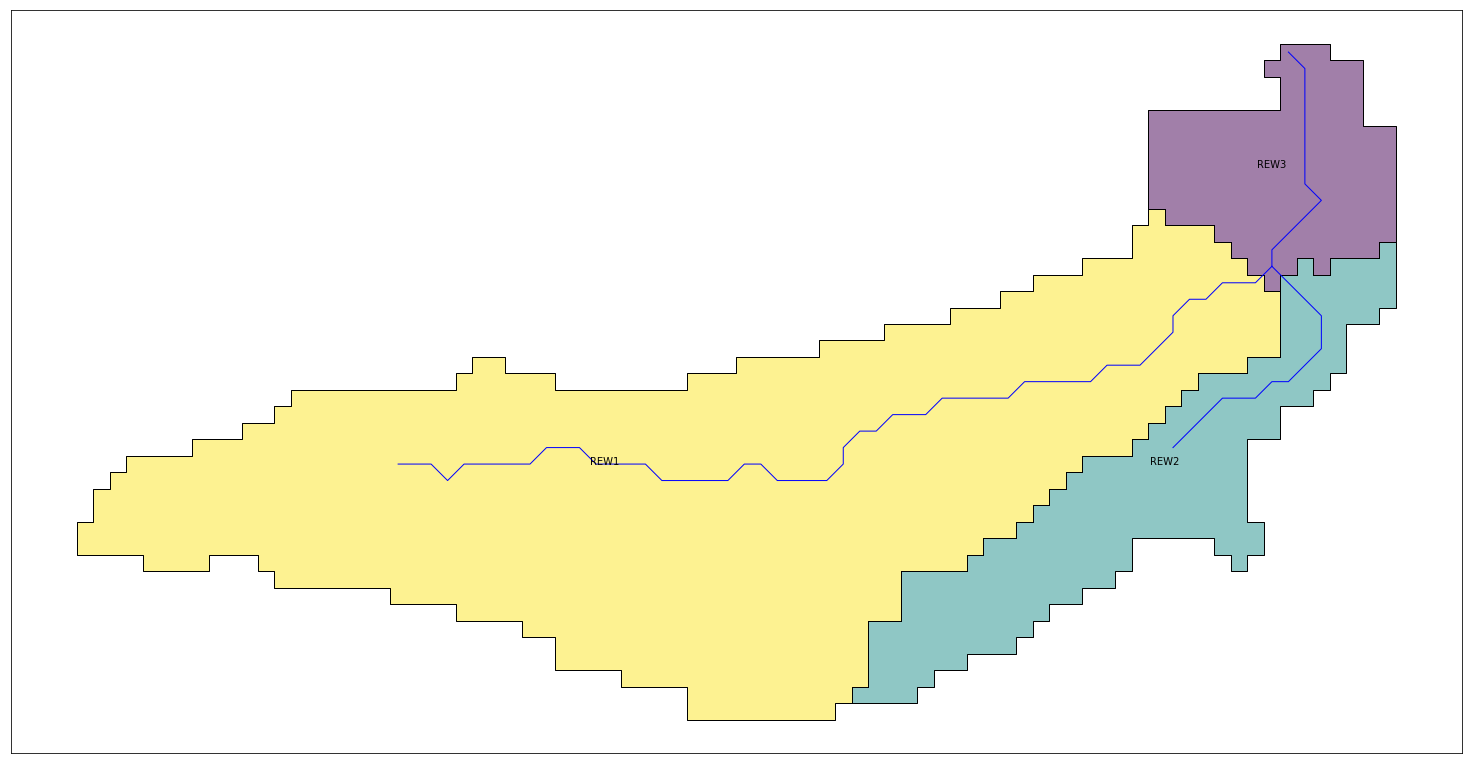

In [16]:
pylab.rcParams['figure.figsize'] = (26, 18)
basins = glob.glob(os.path.join(parent_dir,'raw_data','basins_poly','*.shp'))[0]
basins_shape = gp.GeoDataFrame.from_file(basins)
basins_shape['coords'] = basins_shape['geometry'].apply(lambda x: x.representative_point().coords[:])
basins_shape['coords'] = [coords[0] for coords in basins_shape['coords']]

ax1 = basins_shape.plot()
for idx, row in basins_shape.iterrows():
    print_str = 'REW' + str(row['cat'])
    plt.annotate(s=print_str, xy=row['coords'],
                 horizontalalignment='center',fontsize=10)

try: 
    streams = glob.glob(os.path.join(parent_dir,'raw_data','streams_poly','*.shp'))[0]
    streams_shape = gp.GeoDataFrame.from_file(streams)
    streams_shape.plot(ax=ax1,color='blue')
except: 
    print('There are no identified streams. Watershed can only be run as a single hillslope.')
    
ax1.get_xaxis().set_ticks([])
ax1.get_yaxis().set_ticks([])
ax1.patch.set_facecolor('white')

    

